# Baseline
python: 3.8.*

use ```Ctrl + ]``` to collapse all section :)

Download our starter pack (3~5 min)

In [14]:
# 新增 gdown 到 requirements.txt
%pip install -r requirements.txt

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [15]:
# 從 google drive 下載 data 資料夾
import gdown
url = "https://drive.google.com/drive/folders/1r742uPeVnqUm04qUEZpzzpxXZFbj4gNd"
gdown.download_folder(url, quiet=True, use_cookies=False)


['c:\\Users\\Maggie\\Documents\\Git_Workspace\\2023_spring_NLP\\NLP_final_project\\NCKU-AICUP2023-baseline\\data\\dev_doc5sent5.jsonl',
 'c:\\Users\\Maggie\\Documents\\Git_Workspace\\2023_spring_NLP\\NLP_final_project\\NCKU-AICUP2023-baseline\\data\\dev_doc5sent5.pkl',
 'c:\\Users\\Maggie\\Documents\\Git_Workspace\\2023_spring_NLP\\NLP_final_project\\NCKU-AICUP2023-baseline\\data\\hanlp_con_results.pkl',
 'c:\\Users\\Maggie\\Documents\\Git_Workspace\\2023_spring_NLP\\NLP_final_project\\NCKU-AICUP2023-baseline\\data\\hanlp_con_test_results.pkl',
 'c:\\Users\\Maggie\\Documents\\Git_Workspace\\2023_spring_NLP\\NLP_final_project\\NCKU-AICUP2023-baseline\\data\\public_test.jsonl',
 'c:\\Users\\Maggie\\Documents\\Git_Workspace\\2023_spring_NLP\\NLP_final_project\\NCKU-AICUP2023-baseline\\data\\public_train.jsonl',
 'c:\\Users\\Maggie\\Documents\\Git_Workspace\\2023_spring_NLP\\NLP_final_project\\NCKU-AICUP2023-baseline\\data\\test_doc5.jsonl',
 'c:\\Users\\Maggie\\Documents\\Git_Workspace\\2

In [16]:
# 透過 command line 下載
# !gdown --folder 1r742uPeVnqUm04qUEZpzzpxXZFbj4gNd

# Flow Chart
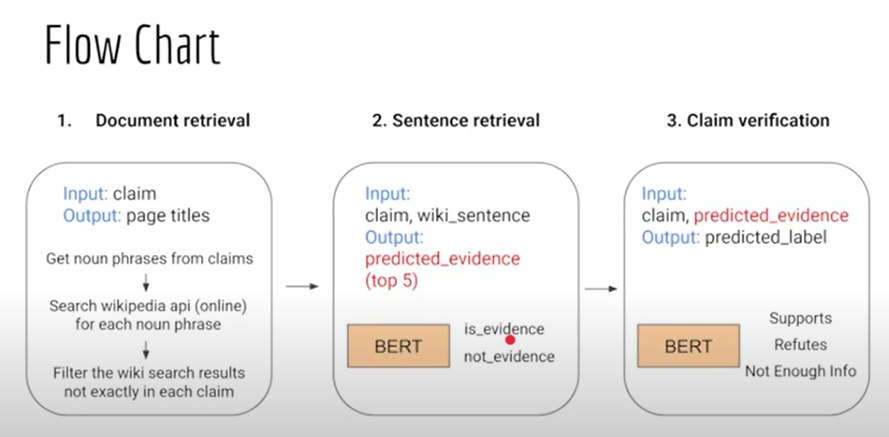

notebook1
# PART 1. Document retrieval

### Preparation
Prepare the environment and import all library we need

In [17]:
# built-in libs
import json
import pickle
import re
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Set, Tuple, Union

# 3rd party libs
import hanlp
import opencc
import pandas as pd
import wikipedia
from hanlp.components.pipeline import Pipeline
from pandarallel import pandarallel

# our own libs
from utils import load_json

pandarallel.initialize(progress_bar=True, verbose=0, nb_workers=10)
wikipedia.set_lang("zh")

Preload the data.

In [18]:
TRAIN_DATA = load_json("data/public_train.jsonl")
TEST_DATA = load_json("data/public_test.jsonl")
CONVERTER_T2S = opencc.OpenCC("t2s.json")
CONVERTER_S2T = opencc.OpenCC("s2t.json")

TRAIN_DATA與TEST_DATA樣子:
- 左邊是TEST_DATA，只有id和claim。
- 右邊是TRAIN_DATA，有id, label, claim, evidence。

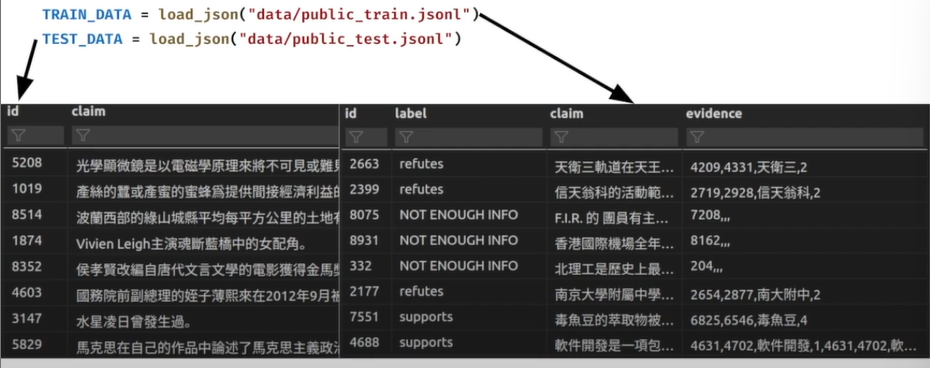

Data class for type hinting

In [19]:
@dataclass
class Claim:
    data: str


@dataclass
class AnnotationID:
    id: int


@dataclass
class EvidenceID:
    id: int


@dataclass
class PageTitle:
    title: str


@dataclass
class SentenceID:
    id: int


@dataclass
class Evidence:
    data: List[List[Tuple[AnnotationID, EvidenceID, PageTitle, SentenceID]]]

### Helper function

For the sake of consistency, we convert traditional to simplified Chinese first before converting it back to traditional Chinese.  This is due to some errors occuring when converting traditional to traditional Chinese.

In [20]:
# 繁體轉簡體再轉繁體
def do_st_corrections(text: str) -> str:
    simplified = CONVERTER_T2S.convert(text)

    return CONVERTER_S2T.convert(simplified)

We use constituency parsing to separate part of speeches or so called constituent to extract noun phrases.  In the later stages, we will use the noun phrases as the query to search for relevant documents.  

In [21]:
# 把claim丟進predictor做pipeline取 noun phrase
def get_nps_hanlp(
    predictor: Pipeline, # 把要做的事情集成pipeline
    d: Dict[str, Union[int, Claim, Evidence]], # TRAIN_DATA或TEST_DATA中的一筆資料(只包含一個claim)
) -> List[str]:
    claim = d["claim"] # string
    tree = predictor(claim)["con"] # parsing tree
    nps = [
        # 將Noun Phrase取出，然後做繁簡繁轉換
        do_st_corrections("".join(subtree.leaves()))
        for subtree in tree.subtrees(lambda t: t.label() == "NP") # 只取出tree中的noun phrase
    ]

    return nps # 這一個claim 產出的 list of noun phrases

`get_nps_hanlp`的輸入輸出:
- 輸入: predictor, d
- 輸出: nps 

    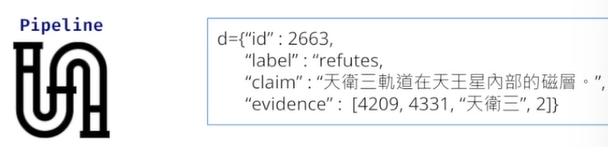
    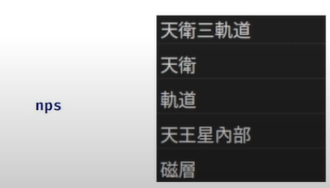


Precision refers to how many related documents are retrieved.  Recall refers to how many relevant documents are retrieved.  

In [22]:
def calculate_precision(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
) -> None:
    precision = 0
    count = 0

    for i, d in enumerate(data):
        if d["label"] == "NOT ENOUGH INFO":
            continue

        # Extract all ground truth of titles of the wikipedia pages
        # evidence[2] refers to the title of the wikipedia page
        gt_pages = set([
            evidence[2]
            for evidence_set in d["evidence"]
            for evidence in evidence_set
        ])

        predicted_pages = predictions.iloc[i]
        hits = predicted_pages.intersection(gt_pages)
        if len(predicted_pages) != 0:
            precision += len(hits) / len(predicted_pages)

        count += 1

    # Macro precision
    print(f"Precision: {precision / count}")


def calculate_recall(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
) -> None:
    recall = 0
    count = 0

    for i, d in enumerate(data):
        if d["label"] == "NOT ENOUGH INFO":
            continue

        gt_pages = set([
            evidence[2]
            for evidence_set in d["evidence"]
            for evidence in evidence_set
        ])
        predicted_pages = predictions.iloc[i]
        hits = predicted_pages.intersection(gt_pages)
        recall += len(hits) / len(gt_pages)
        count += 1

    print(f"Recall: {recall / count}")

The default amount of documents retrieved is at most five documents.  This `num_pred_doc` can be adjusted based on your objective.  Save data in jsonl format.

In [23]:
# 把選出的前五個 wiki 頁面存起來
def save_doc(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
    mode: str = "train",
    num_pred_doc: int = 5,
) -> None:
    with open(
        f"data/{mode}_doc{num_pred_doc}.jsonl",
        "w",
        encoding="utf8",
    ) as f:
        for i, d in enumerate(data):
            d["predicted_pages"] = list(predictions.iloc[i])
            f.write(json.dumps(d, ensure_ascii=False) + "\n")

### Main function for document retrieval

`get_pred_pages`:  
將一個claim當中的noun phrase拿去搜尋wiki的相關頁面，只有「頁面名稱」有出現在claim當中的才會保留下來，最後依據頁面名稱出現在claim當中的位置，選出最靠前面的五個頁面名稱。

In [24]:
# 針對每一筆data(每一個claim的nps)取得相關的前五個wiki頁面
def get_pred_pages(series_data: pd.Series) -> Set[Dict[int, str]]:
    results = [] # list
    tmp_muji = [] # list
    
    # wiki_page: its index showned in claim
    mapping = {} # dict
    claim = series_data["claim"] # string
    nps = series_data["hanlp_results"] # list of noun phrases
    first_wiki_term = [] # list

    #* 針對每一個noun phrase執行:
    for i, np in enumerate(nps):
        wiki_search_results = [
            # wiki API 可以找出與該 noun phrase 有關的頁面名稱(按相關度排序)
            # do_st_corrections 做繁簡繁轉換
            do_st_corrections(w) for w in wikipedia.search(np) 
        ]

        # 去除 wiki page 的後綴()
        wiki_set = [re.sub(r"\s\(\S+\)", "", w) for w in wiki_search_results]
        # 將去掉後綴和沒有去後綴的頁面組成一個dataframe
        wiki_df = pd.DataFrame({
            "wiki_set": wiki_set, # 去掉後綴的頁面
            "wiki_results": wiki_search_results # 沒有去後綴的
        })

        # 將 wiki_set 當作 dataframe 的 index
        grouped_df = wiki_df.groupby("wiki_set", sort=False).first() #把去掉後綴後相同的頁面group by在一起，當作 index
        candidates = grouped_df["wiki_results"].tolist() # 沒有重複的頁面list
        muji = grouped_df.index.tolist()  # 沒有重複的頁面list
        # ? muji 和 candidates 不是一模一樣嗎?
        
        #* 針對該noun phrase的每一個wiki頁面執行:
        for prefix, term in zip(muji, candidates):
            #* 如果這個muji(頁面)還沒match過就執行，如果match過就跳過換下一個頁面。
            if prefix not in tmp_muji: # tmp_muji是match過的頁面名稱 list
                matched = False
                
                #* 步驟1: 如果這是第一個 noun phrase:
                if i == 0:
                    # 將頁面名稱貼上來
                    first_wiki_term.append(term)
                
                #* 步驟2: a. 如果頁面名稱經過字串處理後有在 claim 裡面，則 matched = True
                if (((new_term := term) in claim) or     # 如果term在claim裡面，則令new_term=term               
                    ((new_term := term.replace("·", "")) in claim) or # 如果term 在 replace "." with "" 之後在claim裡面，則令new_term=term
                    ((new_term := term.split(" ")[0]) in claim) or
                    ((new_term := term.replace("-", " ")) in claim)):
                    matched = True # 表示有對應到 claim

                #* 步驟2: b. 如果頁面名稱經過字串處理後"不在" claim 裡面，就試試看處理"·"後有沒有在 claim 裡面
                elif "·" in term: # 處理外國人名中間的點
                    splitted = term.split("·")
                    for split in splitted:
                        if (new_term := split) in claim:
                            matched = True
                            break
                        
                #* 步驟3. 如果頁面名稱有在 claim 中
                if matched: 
                    # post-processing
                    term = term.replace(" ", "_")
                    term = term.replace("-", "")
                    
                    results.append(term) # 將處理過的頁面名稱加入list
                    mapping[term] = claim.find(new_term) # 將處理過的頁面名稱與它在claim中的位置加入dict，例如 {"天王星":6}
                    tmp_muji.append(new_term) # 將頁面名稱加入list

    #* 針對所有nps都執行完後
    #* 如果頁面總數超過五個:
    if len(results) > 5:
        assert -1 not in mapping.values()
        # 依據頁面名稱出現在claim當中的位置做排序，取出最前面的五個頁面名稱
        # TODO: 假設越靠近claim句子的開頭越有相關性
        results = sorted(mapping, key=mapping.get)[:5] 
        
    #* 如果頁面總數為零:   
    elif len(results) < 1:
        # TODO: 那就使用第一個noun phrase的所有wiki頁面名稱
        results = first_wiki_term

    return set(results)

- `wiki_df`: pandas.data.frame。
    - `wiki_set`: 去掉後綴()的頁面名稱 list。
    - `wiki_results`: 沒有去掉後綴()的頁面名稱 list。
- `muji`: 做了group_by，得到不重複的去掉後綴的頁面名稱 list。
- `cadidate`: 做了group_by，得到不重複的沒有去掉後綴的頁面名稱 list。
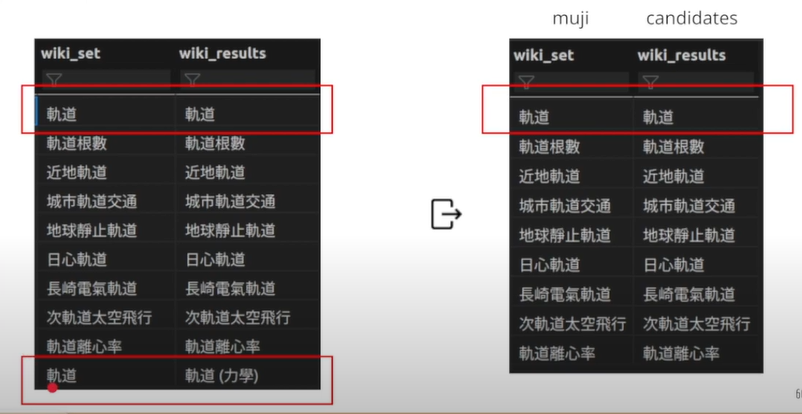  

- 最後輸出`results`: set  
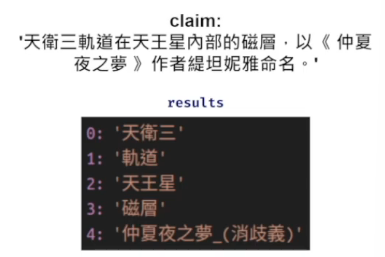

## Part 1 Flow Chart
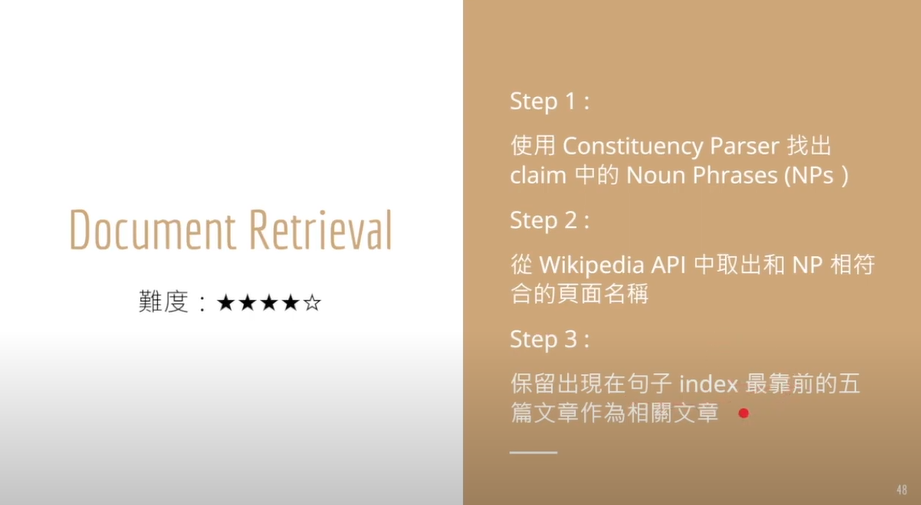

### Step 1. Get noun phrases from hanlp consituency parsing tree

Setup [HanLP](https://github.com/hankcs/HanLP) predictor (1 min)

In [25]:
# predictor裡面會包含一系列動作
predictor = (hanlp.pipeline().append(
    hanlp.load("FINE_ELECTRA_SMALL_ZH"),
    output_key="tok",
).append(
    hanlp.load("CTB9_CON_ELECTRA_SMALL"),
    output_key="con",
    input_key="tok",
))

100%  43.5 MiB  23.0 KiB/s ETA:  0 s [=========================================]
Decompressing C:\Users\Maggie\AppData\Roaming\hanlp\tok/fine_electra_small_20220615_231803.zip to C:\Users\Maggie\AppData\Roaming\hanlp\tok
100%  26.7 KiB  26.7 KiB/s ETA:  0 s [=========================================]
Decompressing C:\Users\Maggie\AppData\Roaming\hanlp\utils/char_table_20210602_202632.json.zip to C:\Users\Maggie\AppData\Roaming\hanlp\utils
100%  41.2 KiB  41.2 KiB/s ETA:  0 s [=========================================]
Decompressing C:\Users\Maggie\AppData\Roaming\hanlp\transformers/electra_zh_small_20210706_125427.zip to C:\Users\Maggie\AppData\Roaming\hanlp\transformers
100%  54.8 MiB   5.2 KiB/s ETA:  0 s [=========================================]
Decompressing C:\Users\Maggie\AppData\Roaming\hanlp\constituency/ctb9_con_electra_small_20220215_230116.zip to C:\Users\Maggie\AppData\Roaming\hanlp\constituency


We will skip this process which for creating parsing tree when demo on class

In [26]:
hanlp_file = f"data/hanlp_con_results.pkl"
if Path(hanlp_file).exists():
    with open(hanlp_file, "rb") as f:
        hanlp_results = pickle.load(f)
else:
    hanlp_results = [get_nps_hanlp(predictor, d) for d in TRAIN_DATA]
    with open(hanlp_file, "wb") as f:
        pickle.dump(hanlp_results, f)

Constituency Parsing Tree的樣子:  
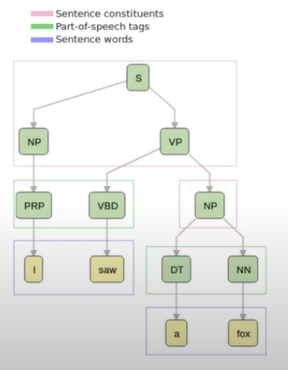

Get pages via wiki online api

In [27]:
doc_path = f"data/train_doc5.jsonl"
if Path(doc_path).exists():
    with open(doc_path, "r", encoding="utf8") as f:
        predicted_results = pd.Series([
            set(json.loads(line)["predicted_pages"])
            for line in f
        ])
else:
    train_df = pd.DataFrame(TRAIN_DATA)
    train_df.loc[:, "hanlp_results"] = hanlp_results
    predicted_results = train_df.parallel_apply(get_pred_pages, axis=1) # 取得每個train data的前五相關wiki頁面
    save_doc(TRAIN_DATA, predicted_results, mode="train")

### Step 2. Calculate our results

In [28]:
calculate_precision(TRAIN_DATA, predicted_results)
calculate_recall(TRAIN_DATA, predicted_results)

Precision: 0.2509375000000056
Recall: 0.8073333333333337


### Step 3. Repeat the same process on test set
Create parsing tree

In [29]:
hanlp_test_file = f"data/hanlp_con_test_results.pkl"
if Path(hanlp_test_file).exists():
    with open(hanlp_file, "rb") as f:
        hanlp_results = pickle.load(f)
else:
    hanlp_results = [get_nps_hanlp(predictor, d) for d in TEST_DATA]
    with open(hanlp_file, "wb") as f:
        pickle.dump(hanlp_results, f)

Get pages via wiki online api

In [30]:
test_doc_path = f"data/test_doc5.jsonl"
if Path(test_doc_path).exists():
    with open(test_doc_path, "r", encoding="utf8") as f:
        test_results = pd.Series(
            [set(json.loads(line)["predicted_pages"]) for line in f])
else:
    test_df = pd.DataFrame(TEST_DATA)
    test_df.loc[:, "hanlp_results"] = hanlp_results
    test_results = test_df.parallel_apply(get_pred_pages, axis=1)
    save_doc(TEST_DATA, test_results, mode="test")

# PART 2. Sentence retrieval

### Preparation
Import some libs

In [31]:
# built-in libs
from pathlib import Path
from typing import Dict, List, Set, Tuple, Union

# third-party libs
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_scheduler,
)

from dataset import BERTDataset, Dataset

# local libs
from utils import (
    generate_evidence_to_wiki_pages_mapping,
    jsonl_dir_to_df,
    load_json,
    load_model,
    save_checkpoint,
    set_lr_scheduler,
)

pandarallel.initialize(progress_bar=True, verbose=0, nb_workers=10)

Global variable

In [32]:
SEED = 42

TRAIN_DATA = load_json("data/public_train.jsonl")
TEST_DATA = load_json("data/public_test.jsonl")
DOC_DATA = load_json("data/train_doc5.jsonl") # 加上wiki五個頁面的TRAIN_DATA

LABEL2ID: Dict[str, int] = {
    "supports": 0,
    "refutes": 1,
    "NOT ENOUGH INFO": 2,
}
ID2LABEL: Dict[int, str] = {v: k for k, v in LABEL2ID.items()}

_y = [LABEL2ID[data["label"]] for data in TRAIN_DATA]
# GT means Ground Truth
TRAIN_GT, DEV_GT = train_test_split(
    DOC_DATA,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
    stratify=_y,
)

Preload wiki database (1 min)

In [33]:
wiki_pages = jsonl_dir_to_df("data/wiki-pages")
mapping = generate_evidence_to_wiki_pages_mapping(wiki_pages)
del wiki_pages

Reading and concatenating jsonl files in data/wiki-pages
Generate parse mapping


Transform to id to evidence_map mapping


### Helper function

Calculate precision for sentence retrieval

In [34]:
def evidence_macro_precision(
    instance: Dict,
    top_rows: pd.DataFrame,
) -> Tuple[float, float]:
    
    """Calculate precision for sentence retrieval
    This function is modified from fever-scorer.
    https://github.com/sheffieldnlp/fever-scorer/blob/master/src/fever/scorer.py

    Args:
        instance (dict): a row of the dev set (dev.jsonl) of test set (test.jsonl)
        top_rows (pd.DataFrame): our predictions with the top probabilities

        IMPORTANT!!!
        instance (dict) should have the key of `evidence`.
        top_rows (pd.DataFrame) should have a column `predicted_evidence`.

    Returns:
        Tuple[float, float]:
        [1]: relevant and retrieved (numerator of precision)
        [2]: retrieved (denominator of precision)
    """
    this_precision = 0.0
    this_precision_hits = 0.0

    # Return 0, 0 if label is "not enough info" since not enough info does not
    # contain any evidence.
    if instance["label"].upper() != "NOT ENOUGH INFO":
        # e[2] is the page title, e[3] is the sentence index
        all_evi = [[e[2], e[3]]
                   for eg in instance["evidence"]
                   for e in eg
                   if e[3] is not None]
        claim = instance["claim"]
        # 取出對應的evidence
        predicted_evidence = top_rows[top_rows["claim"] ==
                                      claim]["predicted_evidence"].tolist()

        # 計算 precision
        for prediction in predicted_evidence:
            if prediction in all_evi:
                this_precision += 1.0
            this_precision_hits += 1.0

        return (this_precision /
                this_precision_hits) if this_precision_hits > 0 else 1.0, 1.0

    return 0.0, 0.0

Calculate recall for sentence retrieval

In [35]:
def evidence_macro_recall(
    instance: Dict,
    top_rows: pd.DataFrame,
) -> Tuple[float, float]:
    
    """Calculate recall for sentence retrieval
    This function is modified from fever-scorer.
    https://github.com/sheffieldnlp/fever-scorer/blob/master/src/fever/scorer.py

    Args:
        instance (dict): a row of the dev set (dev.jsonl) of test set (test.jsonl)
        top_rows (pd.DataFrame): our predictions with the top probabilities

        IMPORTANT!!!
        instance (dict) should have the key of `evidence`.
        top_rows (pd.DataFrame) should have a column `predicted_evidence`.

    Returns:
        Tuple[float, float]:
        [1]: relevant and retrieved (numerator of recall)
        [2]: relevant (denominator of recall)
    """
    # We only want to score F1/Precision/Recall of recalled evidence for NEI claims
    if instance["label"].upper() != "NOT ENOUGH INFO":
        # If there's no evidence to predict, return 1
        if len(instance["evidence"]) == 0 or all(
            [len(eg) == 0 for eg in instance]):
            return 1.0, 1.0

        claim = instance["claim"]

        predicted_evidence = top_rows[top_rows["claim"] ==
                                      claim]["predicted_evidence"].tolist()

        for evidence_group in instance["evidence"]:
            evidence = [[e[2], e[3]] for e in evidence_group]
            # 如果 ground truth的每個evidence都在predicted_evidence裡面，才回傳1,1
            if all([item in predicted_evidence for item in evidence]): 
                # We only want to score complete groups of evidence. Incomplete
                # groups are worthless.
                return 1.0, 1.0
        return 0.0, 1.0
    return 0.0, 0.0

Calculate the scores of sentence retrieval

In [36]:
def evaluate_retrieval(
    probs: np.ndarray,
    df_evidences: pd.DataFrame,
    ground_truths: pd.DataFrame,
    top_n: int = 5,
    cal_scores: bool = True,
    save_name: str = None,
) -> Dict[str, float]:
    
    """
    Calculate the scores of sentence retrieval

    Args:
        probs (np.ndarray): probabilities of the candidate retrieved sentences
        df_evidences (pd.DataFrame): the candiate evidence sentences paired with claims
        ground_truths (pd.DataFrame): the loaded data of dev.jsonl or test.jsonl
        top_n (int, optional): the number of the retrieved sentences. Defaults to 2.

    Returns:
        Dict[str, float]: F1 score, precision, and recall
    """
    df_evidences["prob"] = probs
    # 取出前n個機率最高的df_evidences
    top_rows = (
        df_evidences.groupby("claim").apply(
        lambda x: x.nlargest(top_n, "prob"))
        .reset_index(drop=True)
    )

    if cal_scores:
        macro_precision = 0
        macro_precision_hits = 0
        macro_recall = 0
        macro_recall_hits = 0

        for i, instance in enumerate(ground_truths):
            macro_prec = evidence_macro_precision(instance, top_rows)
            macro_precision += macro_prec[0]
            macro_precision_hits += macro_prec[1]

            macro_rec = evidence_macro_recall(instance, top_rows)
            macro_recall += macro_rec[0]
            macro_recall_hits += macro_rec[1]

        # 計算指標
        pr = (macro_precision /
              macro_precision_hits) if macro_precision_hits > 0 else 1.0
        rec = (macro_recall /
               macro_recall_hits) if macro_recall_hits > 0 else 0.0
        f1 = 2.0 * pr * rec / (pr + rec)

    # 寫入檔案
    if save_name is not None:
        # write doc7_sent5 file
        with open(f"data/{save_name}", "w") as f:
            for instance in ground_truths:
                claim = instance["claim"]
                predicted_evidence = top_rows[
                    top_rows["claim"] == claim]["predicted_evidence"].tolist()
                instance["predicted_evidence"] = predicted_evidence
                f.write(json.dumps(instance, ensure_ascii=False) + "\n")

    if cal_scores:
        return {"F1 score": f1, "Precision": pr, "Recall": rec}

Inference script to get probabilites for the candidate evidence sentences

In [37]:
# 計算positive的機率
def get_predicted_probs(
    model: nn.Module,
    dataloader: Dataset,
    device: torch.device,
) -> np.ndarray:
    """Inference script to get probabilites for the candidate evidence sentences

    Args:
        model: the one from HuggingFace Transformers
        dataloader: devset or testset in torch dataloader

    Returns:
        np.ndarray: probabilites of the candidate evidence sentences
    """
    model.eval() # 開啟 evaluation 模式
    probs = []

    with torch.no_grad(): # 不要做 gradient 計算
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            # 算出機率後只取 positive 的機率
            probs.extend(torch.softmax(logits, dim=1)[:, 1].tolist())

    return np.array(probs) # 回傳 positive 的機率

```python
probs.extend(torch.softmax(logits, dim=1)[:, 1].tolist())
```
只取第二列(label為1的機率)

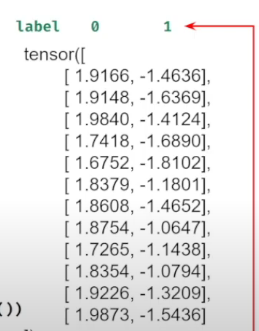

AicupTopkEvidenceBERTDataset class for AICUP dataset with top-k evidence sentences

In [38]:
class SentRetrievalBERTDataset(BERTDataset):
    """AicupTopkEvidenceBERTDataset class for AICUP dataset with top-k evidence sentences."""

    def __getitem__( 
        self,
        idx: int,
        **kwargs,
    ) -> Tuple[Dict[str, torch.Tensor], int]: # 回傳經過 torch.tokenizer的 claim, wiki相關句, label
        item = self.data.iloc[idx]
        sentA = item["claim"] # claim
        sentB = item["text"] # 用空格串起的句子們

        # claim [SEP] text
        concat = self.tokenizer(
            sentA, # claim
            sentB, # 用空格串起的句子們
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
        )
        # 轉成 tensor
        concat_ten = {k: torch.tensor(v) for k, v in concat.items()}
        if "label" in item:
            concat_ten["labels"] = torch.tensor(item["label"]) # 再加上 label 的 tensor

        return concat_ten

輸出:
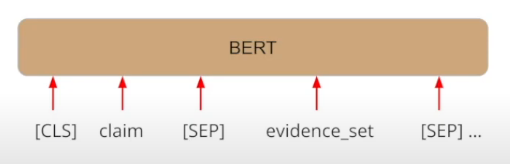

### Main function for sentence retrieval

In [39]:

def pair_with_wiki_sentences(
    mapping: Dict[str, Dict[int, str]], # 把wiki_pages資料夾內的資料整理成一個字典 {頁面名稱: {index: 句子}}
    df: pd.DataFrame, # DOC_DATA中的training split
    negative_ratio: float,
) -> pd.DataFrame:
    """Only for creating train sentences."""
    claims = []
    sentences = []
    labels = []

    #* 針對每一個 claim 執行:
    for i in range(len(df)):
        #* 如果NOT ENOUGH INFO就跳過
        if df["label"].iloc[i] == "NOT ENOUGH INFO":
            continue 

        claim = df["claim"].iloc[i]
        evidence_sets = df["evidence"].iloc[i] # 該claim的evidence，[[[6635,6392,'真靈長大目',3]]]
        for evidence_set in evidence_sets: # 針對evidence中每一個句子組
            sents = []
            for evidence in evidence_set: # 針對句子組中每一個句子
                # evidence[2] 是頁面名稱
                page = evidence[2].replace(" ", "_") # 把空格替換成底線
                # 特殊例外處理的句子
                if page == "臺灣海峽危機#第二次臺灣海峽危機（1958）":
                    continue
                # evidence[3] 是句子的index
                sent_idx = str(evidence[3]) # 取出句子的index
                sents.append(mapping[page][sent_idx]) # 將該句子內容加到 sents list 中

            # 將同一組的句子用空格連接起來
            whole_evidence = " ".join(sents)

            claims.append(claim) # 把該claim加到list
            sentences.append(whole_evidence) # 將用空格串連的句子組加到list
            labels.append(1) # 表示 positive

  
    #* 針對每一個 claim 執行:
    for i in range(len(df)):
        #* 如果NOT ENOUGH INFO就跳過
        if df["label"].iloc[i] == "NOT ENOUGH INFO":
            continue
        
        claim = df["claim"].iloc[i]
        #! 取得 evidence set((頁面名稱,句子index),(頁面名稱,句子index),...)
        evidence_set = set([(evidence[2], evidence[3]) # evidence[2] 是頁面名稱，evidence[3] 是句子的index
                            for evidences in  df["evidence"][i]
                            for evidence in evidences])
        
        #! 第一階段最後的產出，wiki 頁面前五筆的index和頁面
        predicted_pages = df["predicted_pages"][i] 
        for page in predicted_pages: #* 針對每個 wiki 頁面
            page = page.replace(" ", "_")
            try:
                #! 得到 predicted list [(頁面:句子index),(頁面:句子index),...]
                page_sent_id_pairs = [ 
                    (page, sent_idx) for sent_idx in mapping[page].keys()
                ]
            except KeyError:
                # print(f"{page} is not in our Wiki db.")
                continue

            #* 針對每一對 wiki (頁面:句子index)
            for pair in page_sent_id_pairs: 
                #! 如果 positive (wiki (頁面:句子index) 有在 evidence_set 中)
                if pair in evidence_set: 
                    continue
                #! 以下只有 negative (wiki (頁面:句子index) 不在 evidence_set 中) 才會執行
                text = mapping[page][pair[1]] # wiki句子內容
                # `np.random.rand(1) <= 0.05`: Control not to add too many negative samples
                if text != "" and np.random.rand(1) <= negative_ratio: # 為了避免 positive 與 negative 資料數量不平衡，所以用threshold控制
                    claims.append(claim)
                    sentences.append(text)
                    labels.append(0)
                    
    # 回傳 {claim, 句子內容, labels}
    return pd.DataFrame({"claim": claims, "text": sentences, "label": labels})


def pair_with_wiki_sentences_eval(
    mapping: Dict[str, Dict[int, str]],
    df: pd.DataFrame,
    is_testset: bool = False,
) -> pd.DataFrame:
    """Only for creating dev and test sentences."""
    claims = []
    sentences = []
    evidence = []
    predicted_evidence = []

    # negative
    for i in range(len(df)):
        
        claim = df["claim"].iloc[i]

        predicted_pages = df["predicted_pages"][i]
        for page in predicted_pages:
            page = page.replace(" ", "_")
            try:
                page_sent_id_pairs = [(page, k) for k in mapping[page]]
            except KeyError:
                # print(f"{page} is not in our Wiki db.")
                continue

            for page_name, sentence_id in page_sent_id_pairs:
                text = mapping[page][sentence_id] # wiki句子內容
                if text != "": # wiki句子非空
                    claims.append(claim)
                    sentences.append(text)
                    if not is_testset:
                        evidence.append(df["evidence"].iloc[i])
                    predicted_evidence.append([page_name, int(sentence_id)])

    return pd.DataFrame({
        "claim": claims,
        "text": sentences,
        "evidence": evidence if not is_testset else None,
        "predicted_evidence": predicted_evidence,
    })

- `claim`
- `evidence_set`
- `predicted_pages`  
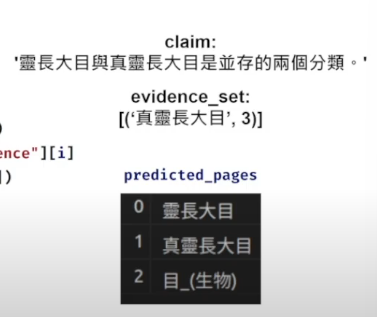

- `page_sent_id_pairs`  
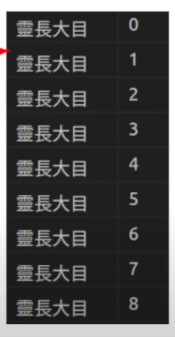

- `claims`
- `sentences`
- `labels`  
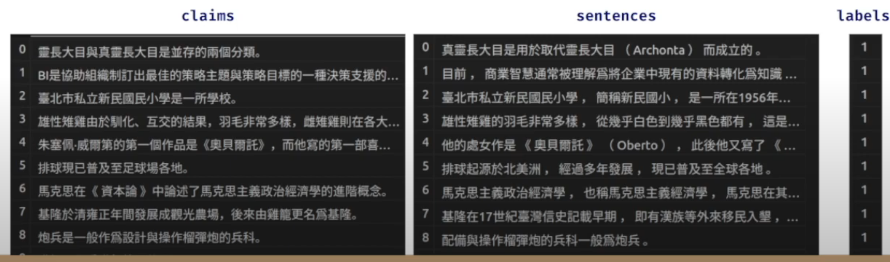

## Part 2 Flow Chart
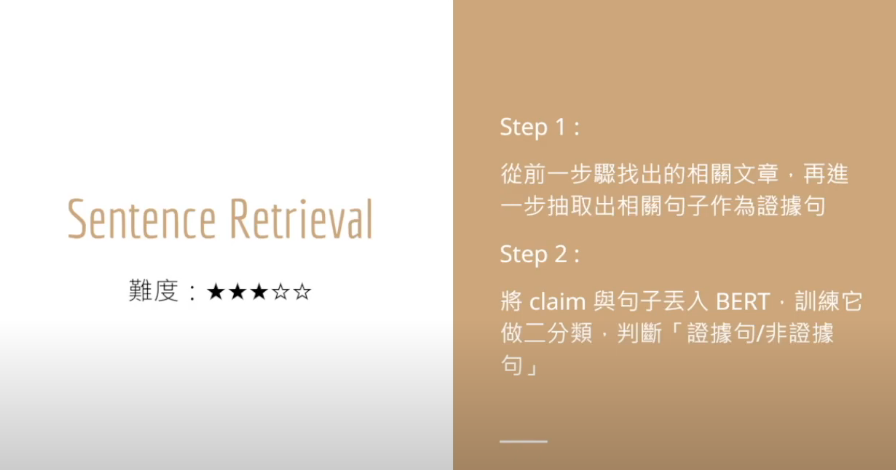

### Step 1. Setup training environment

Hyperparams

In [40]:
#@title  { display-mode: "form" }

MODEL_NAME = "bert-base-chinese"  #@param {type:"string"}
NUM_EPOCHS = 1  #@param {type:"integer"}
LR = 2e-5  #@param {type:"number"}
TRAIN_BATCH_SIZE = 64  #@param {type:"integer"} 如果CUDA out of memory 就調小(通常為2的次方)
TEST_BATCH_SIZE = 256  #@param {type:"integer"}
NEGATIVE_RATIO = 0.03  #@param {type:"number"}
VALIDATION_STEP = 50  #@param {type:"integer"}
TOP_N = 5  #@param {type:"integer"} 輸出前五筆，與doc retrieval 同樣設定

Experiment Directory

In [41]:
# 一些資料夾存放位置而已
EXP_DIR = f"sent_retrieval/e{NUM_EPOCHS}_bs{TRAIN_BATCH_SIZE}_" + f"{LR}_neg{NEGATIVE_RATIO}_top{TOP_N}"
LOG_DIR = "logs/" + EXP_DIR
CKPT_DIR = "checkpoints/" + EXP_DIR

if not Path(LOG_DIR).exists():
    Path(LOG_DIR).mkdir(parents=True)

if not Path(CKPT_DIR).exists():
    Path(CKPT_DIR).mkdir(parents=True)

### Step 2. Combine claims and evidences

In [42]:
# {claim, 句子內容, labels}
train_df = pair_with_wiki_sentences(
    mapping, # 就是把wiki_pages資料夾內的資料整理成一個字典{頁面名稱: {index: 句子}}
    pd.DataFrame(TRAIN_GT), # train data
    NEGATIVE_RATIO, # 自訂的threshold
)

counts = train_df["label"].value_counts() 
print("Now using the following train data with 0 (Negative) and 1 (Positive)")
print(counts)

dev_evidences = pair_with_wiki_sentences_eval(mapping, pd.DataFrame(DEV_GT))

Now using the following train data with 0 (Negative) and 1 (Positive)
1    2774
0    2643
Name: label, dtype: int64


### Step 3. Start training

Dataloader things

In [43]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = SentRetrievalBERTDataset(train_df, tokenizer=tokenizer)
val_dataset = SentRetrievalBERTDataset(dev_evidences, tokenizer=tokenizer)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE,
)
eval_dataloader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE)

c:\Users\Maggie\miniconda3\envs\NLP_final\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Maggie\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Save your memory.

In [44]:
del train_df

Trainer

In [45]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = set_lr_scheduler(optimizer, num_training_steps)

writer = SummaryWriter(LOG_DIR)

Please make sure that you are using gpu when training (5 min)

In [46]:
progress_bar = tqdm(range(num_training_steps))
current_steps = 0

for epoch in range(NUM_EPOCHS):
    model.train() # 設定為 training 模式

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch) # **表示展開dict
        loss = outputs.loss
        loss.backward() # backpropagation

        optimizer.step() # 更新 weights
        lr_scheduler.step() # 更新 weights
        optimizer.zero_grad() # 將梯度歸零(清空 gradient buffer)
        progress_bar.update(1) 
        writer.add_scalar("training_loss", loss.item(), current_steps)

        # 取出機率最大的label
        y_pred = torch.argmax(outputs.logits, dim=1).tolist()
        y_true = batch["labels"].tolist()

        current_steps += 1

        # 到達一定的step就會做 validation 並 output 到 tensorboard
        if current_steps % VALIDATION_STEP == 0 and current_steps > 0:
            print("Start validation")
            probs = get_predicted_probs(model, eval_dataloader, device)

            val_results = evaluate_retrieval(
                probs=probs,
                df_evidences=dev_evidences,
                ground_truths=DEV_GT,
                top_n=TOP_N,
            )
            print(val_results)

            # log each metric separately to TensorBoard
            for metric_name, metric_value in val_results.items():
                writer.add_scalar(
                    f"dev_{metric_name}",
                    metric_value,
                    current_steps,
                )

            save_checkpoint(model, CKPT_DIR, current_steps)

print("Finished training!")

  0%|          | 0/85 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

Validation part (15 mins)

In [ ]:
# 載入存好的 model
ckpt_name = "model.50.pt"  #@param {type:"string"}
model = load_model(model, ckpt_name, CKPT_DIR) # 定義在 utils.py 
print("Start final evaluations and write prediction files.")

# 取得 wiki sentences
train_evidences = pair_with_wiki_sentences_eval(
    mapping=mapping,
    df=pd.DataFrame(TRAIN_GT),
)
train_set = SentRetrievalBERTDataset(train_evidences, tokenizer)
train_dataloader = DataLoader(train_set, batch_size=TEST_BATCH_SIZE)

print("Start calculating training scores")
probs = get_predicted_probs(model, train_dataloader, device)
train_results = evaluate_retrieval(
    probs=probs,
    df_evidences=train_evidences,
    ground_truths=TRAIN_GT,
    top_n=TOP_N,
    save_name=f"train_doc5sent{TOP_N}.jsonl",
)
print(f"Training scores => {train_results}")

print("Start validation")
probs = get_predicted_probs(model, eval_dataloader, device)
val_results = evaluate_retrieval(
    probs=probs,
    df_evidences=dev_evidences,
    ground_truths=DEV_GT,
    top_n=TOP_N,
    save_name=f"dev_doc5sent{TOP_N}.jsonl", # 這階段的主要輸出
)

print(f"Validation scores => {val_results}")

### Step 4. Check on our test data
(5 min)

In [ ]:
test_data = load_json("data/test_doc5.jsonl")

test_evidences = pair_with_wiki_sentences_eval(
    mapping,
    pd.DataFrame(test_data),
    is_testset=True,
)
test_set = SentRetrievalBERTDataset(test_evidences, tokenizer)
test_dataloader = DataLoader(test_set, batch_size=TEST_BATCH_SIZE)

print("Start predicting the test data")
probs = get_predicted_probs(model, test_dataloader, device)
evaluate_retrieval(
    probs=probs,
    df_evidences=test_evidences,
    ground_truths=test_data,
    top_n=TOP_N,
    cal_scores=False,
    save_name=f"test_doc5sent{TOP_N}.jsonl",
)

notebook3
# PART 3. Claim verification

### Preparation
import libs

In [ ]:
import pickle
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
from pandarallel import pandarallel
from tqdm.auto import tqdm

import torch
from sklearn.metrics import accuracy_score
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_scheduler,
)

from dataset import BERTDataset
from utils import (
    generate_evidence_to_wiki_pages_mapping,
    jsonl_dir_to_df,
    load_json,
    load_model,
    save_checkpoint,
    set_lr_scheduler,
)

pandarallel.initialize(progress_bar=True, verbose=0, nb_workers=4)

Global variables

In [ ]:
LABEL2ID: Dict[str, int] = {
    "supports": 0,
    "refutes": 1,
    "NOT ENOUGH INFO": 2,
}
ID2LABEL: Dict[int, str] = {v: k for k, v in LABEL2ID.items()}

TRAIN_DATA = load_json("data/train_doc5sent5.jsonl")
DEV_DATA = load_json("data/dev_doc5sent5.jsonl")

TRAIN_PKL_FILE = Path("data/train_doc5sent5.pkl")
DEV_PKL_FILE = Path("data/dev_doc5sent5.pkl")

Preload wiki database (same as part 2.)

In [ ]:
wiki_pages = jsonl_dir_to_df("data/wiki-pages")
mapping = generate_evidence_to_wiki_pages_mapping(wiki_pages,)
del wiki_pages

`generate_evidence_to_wiki_pages_mapping`: 把wiki_pages dataframe轉換成dict包著dict。  
輸出: `{"頁面名稱":{"句子index":"句子內容"}}`  

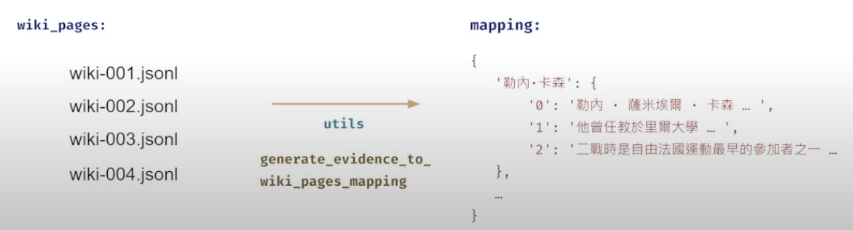

### Helper function

AICUP dataset with top-k evidence sentences.

In [ ]:
class AicupTopkEvidenceBERTDataset(BERTDataset):
    """AICUP dataset with top-k evidence sentences."""

    def __getitem__(
        self,
        idx: int, # 輸入 index
        **kwargs,
    ) -> Tuple[Dict[str, torch.Tensor], int]:
        item = self.data.iloc[idx]
        claim = item["claim"]
        evidence = item["evidence_list"]

        # In case there are less than topk evidence sentences
        pad = ["[PAD]"] * (self.topk - len(evidence))
        evidence += pad
        concat_claim_evidence = " [SEP] ".join([*claim, *evidence]) # *表示展開list

        concat = self.tokenizer(
            concat_claim_evidence,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
        )
        # LABEL2ID 將 support, refutes, not enough info 轉成 0,1,2
        label = LABEL2ID[item["label"]] if "label" in item else -1
        # 轉成 tensor
        concat_ten = {k: torch.tensor(v) for k, v in concat.items()}

        if "label" in item:
            concat_ten["labels"] = torch.tensor(label)

        return concat_ten

Evaluation function

In [ ]:
def run_evaluation(model: torch.nn.Module, dataloader: DataLoader, device):
    model.eval() # 記得使用eval模式

    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            y_true.extend(batch["labels"].tolist())

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss += outputs.loss.item() # loss累加
            logits = outputs.logits
            y_pred.extend(torch.argmax(logits, dim=1).tolist()) #取得機率最高的

    acc = accuracy_score(y_true, y_pred)

    return {"val_loss": loss / len(dataloader), "val_acc": acc}

Prediction

In [ ]:
def run_predict(model: torch.nn.Module, test_dl: DataLoader, device) -> list:
    model.eval() # 記得使用eval模式

    preds = []
    for batch in tqdm(test_dl,
                      total=len(test_dl),
                      leave=False,
                      desc="Predicting"):
        batch = {k: v.to(device) for k, v in batch.items()}
        pred = model(**batch).logits
        pred = torch.argmax(pred, dim=1)
        preds.extend(pred.tolist())
    return preds

### Main function

In [ ]:
# join the dataset with topk evidence.
def join_with_topk_evidence(
    df: pd.DataFrame,
    mapping: dict,
    mode: str = "train",
    topk: int = 5,
) -> pd.DataFrame:
    """join_with_topk_evidence join the dataset with topk evidence.

    Note:
        After extraction, the dataset will be like this:
               id     label         claim                           evidence            evidence_list
        0    4604  supports       高行健...     [[[3393, 3552, 高行健, 0], [...  [高行健 （ ）江西赣州出...
        ..    ...       ...            ...                                ...                     ...
        945  2095  supports       美國總...  [[[1879, 2032, 吉米·卡特, 16], [...  [卸任后 ， 卡特積極參與...
        停各种战争及人質危機的斡旋工作 ， 反对美国小布什政府攻打伊拉克...

        [946 rows x 5 columns]

    Args:
        df (pd.DataFrame): The dataset with evidence.
        wiki_pages (pd.DataFrame): The wiki pages dataframe
        topk (int, optional): The topk evidence. Defaults to 5.
        cache(Union[Path, str], optional): The cache file path. Defaults to None.
            If cache is None, return the result directly.

    Returns:
        pd.DataFrame: The dataset with topk evidence_list.
            The `evidence_list` column will be: List[str]
    """

    # format evidence column to List[List[Tuple[str, str, str, str]]]
    if "evidence" in df.columns:
        df["evidence"] = df["evidence"].parallel_map(
            lambda x: [[x]] if not isinstance(x[0], list) else [x]
            if not isinstance(x[0][0], list) else x)

    print(f"Extracting evidence_list for the {mode} mode ...")
    
    if mode == "eval":
        # extract evidence
        df["evidence_list"] = df["predicted_evidence"].parallel_map(lambda x: [
            mapping.get(evi_id, {}).get(str(evi_idx), "")
            for evi_id, evi_idx in x  # for each evidence list
        ][:topk] if isinstance(x, list) else [])
        print(df["evidence_list"][:5])
    else:
        # extract evidence
        df["evidence_list"] = df["evidence"].parallel_map(lambda x: [
            " ".join([  # !與上面不同: 使用空格 join evidence
                mapping.get(evi_id, {}).get(str(evi_idx), "")
                for _, _, evi_id, evi_idx in evi_list
            ]) if isinstance(evi_list, list) else ""
            for evi_list in x  # for each evidence list
        ][:1] if isinstance(x, list) else [])

    return df

`join_with_topk_evidence` 輸出的樣子:
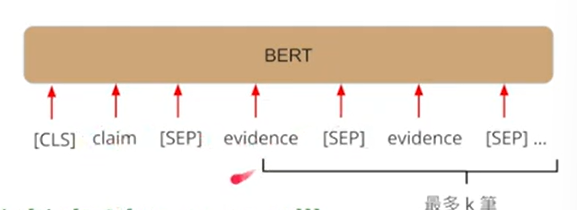

## Part 3 Flow Chart
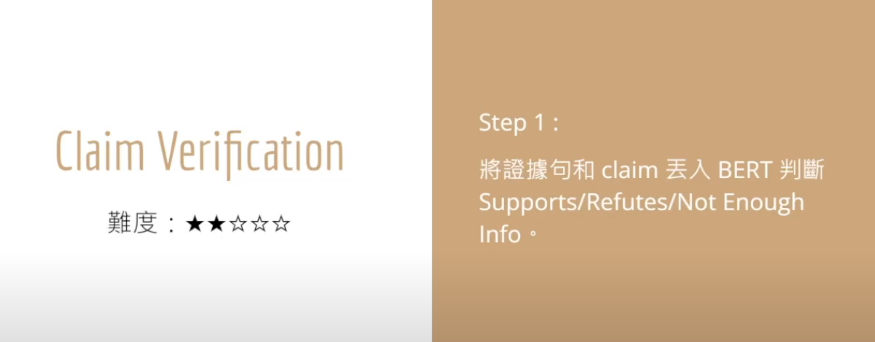

### Step 1. Setup training environment

Hyperparams

In [ ]:
#@title  { display-mode: "form" }

MODEL_NAME = "bert-base-chinese"  #@param {type:"string"}
TRAIN_BATCH_SIZE = 32  #@param {type:"integer"}
TEST_BATCH_SIZE = 32  #@param {type:"integer"}
SEED = 42  #@param {type:"integer"}
LR = 7e-5  #@param {type:"number"}
NUM_EPOCHS = 20  #@param {type:"integer"}
MAX_SEQ_LEN = 256  #@param {type:"integer"}
EVIDENCE_TOPK = 5  #@param {type:"integer"}
VALIDATION_STEP = 25  #@param {type:"integer"}


Experiment Directory

In [ ]:
OUTPUT_FILENAME = "submission.jsonl"

EXP_DIR = f"claim_verification/e{NUM_EPOCHS}_bs{TRAIN_BATCH_SIZE}_" + f"{LR}_top{EVIDENCE_TOPK}"
LOG_DIR = "logs/" + EXP_DIR
CKPT_DIR = "checkpoints/" + EXP_DIR

if not Path(LOG_DIR).exists():
    Path(LOG_DIR).mkdir(parents=True)

if not Path(CKPT_DIR).exists():
    Path(CKPT_DIR).mkdir(parents=True)

### Step 2. Concat claim and evidences
join topk evidence

In [ ]:
# 如果沒有這個檔案，就產生這階段要用的訓練資料
if not TRAIN_PKL_FILE.exists():
    train_df = join_with_topk_evidence(
        pd.DataFrame(TRAIN_DATA),
        mapping,
        topk=EVIDENCE_TOPK,
    )
    train_df.to_pickle(TRAIN_PKL_FILE, protocol=4)
else:
    with open(TRAIN_PKL_FILE, "rb") as f:
        train_df = pickle.load(f)

if not DEV_PKL_FILE.exists():
    dev_df = join_with_topk_evidence(
        pd.DataFrame(DEV_DATA),
        mapping,
        mode="eval",
        topk=EVIDENCE_TOPK,
    )
    dev_df.to_pickle(DEV_PKL_FILE, protocol=4)
else:
    with open(DEV_PKL_FILE, "rb") as f:
        dev_df = pickle.load(f)

### Step 3. Training

Prevent CUDA out of memory

In [ ]:
torch.cuda.empty_cache()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = AicupTopkEvidenceBERTDataset(
    train_df,
    tokenizer=tokenizer,
    max_length=MAX_SEQ_LEN,
)
val_dataset = AicupTopkEvidenceBERTDataset(
    dev_df,
    tokenizer=tokenizer,
    max_length=MAX_SEQ_LEN,
)

# 把 dataset 讀近來並包裝成每個batch要取出來的樣子
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE,
)
eval_dataloader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, # "bert-base-chinese"
    num_labels=len(LABEL2ID),
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = set_lr_scheduler(optimizer, num_training_steps)

# 視覺化
writer = SummaryWriter(LOG_DIR) 

Training (30 mins)

In [ ]:
# 跟 Part 2 一模一樣
progress_bar = tqdm(range(num_training_steps))
current_steps = 0

for epoch in range(NUM_EPOCHS):
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad() # !重要:記得清空梯度確保batch之間是獨立的
        progress_bar.update(1)
        writer.add_scalar("training_loss", loss.item(), current_steps)

        y_pred = torch.argmax(outputs.logits, dim=1).tolist()
        y_true = batch["labels"].tolist()

        current_steps += 1

        if current_steps % VALIDATION_STEP == 0 and current_steps > 0:
            print("Start validation")
            val_results = run_evaluation(model, eval_dataloader, device)

            # log each metric separately to TensorBoard
            for metric_name, metric_value in val_results.items():
                print(f"{metric_name}: {metric_value}")
                writer.add_scalar(f"{metric_name}", metric_value, current_steps)

            save_checkpoint(
                model,
                CKPT_DIR,
                current_steps,
                mark=f"val_acc={val_results['val_acc']:.4f}",
            )

print("Finished training!")

### Step 4. Make your submission

In [ ]:
TEST_DATA = load_json("data/test_doc5sent5.jsonl")
TEST_PKL_FILE = Path("data/test_doc5sent5.pkl")

# 把資料 join_with_topk_evidence 後存檔
if not TEST_PKL_FILE.exists():
    test_df = join_with_topk_evidence(
        pd.DataFrame(TEST_DATA),
        mapping,
        mode="eval",
        topk=EVIDENCE_TOPK,
    )
    test_df.to_pickle(TEST_PKL_FILE, protocol=4)
else:
    with open(TEST_PKL_FILE, "rb") as f:
        test_df = pickle.load(f)

# 再把資料轉成 dataset的形式
test_dataset = AicupTopkEvidenceBERTDataset(
    test_df,
    tokenizer=tokenizer,
    max_length=MAX_SEQ_LEN,
)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

Prediction

In [ ]:
# TODO: 改成我們最好的 checkpoint
ckpt_name = "val_acc=0.4259_model.750.pt"  #@param {type:"string"}
model = load_model(model, ckpt_name, CKPT_DIR)
predicted_label = run_predict(model, test_dataloader, device)

Write files

In [ ]:
predict_dataset = test_df.copy()
# 將數字轉回原本的labels
predict_dataset["predicted_label"] = list(map(ID2LABEL.get, predicted_label))
# 轉成 JSON 檔
predict_dataset[["id", "predicted_label", "predicted_evidence"]].to_json(
    OUTPUT_FILENAME,
    orient="records",
    lines=True,
    force_ascii=False,
)